# 👹 Adversarial training

## Network insensitivity to parameter noise via adversarial regularization
This tutorial shows how to use the adversarial loss for increasing robustness to component mismatch.

The high-level description of the algorithm is as follows:
In each training iteration, the network parameters are attacked by an adversary, whose goal it is to maximize the entity $\mathcal{L}_{rob}$, which is a loss function taking as arguments the outputs of the network using the attacked parameters and the original parameters. The loss function is traditionally chosen as the KL-divergence between the softmaxed logits of both networks. In this tutorial, the MSE was chosen.

The final loss that is being optimized is $\mathcal{L} = \mathcal{L}_{training}(f(X,\Theta)) + \beta_{rob} \cdot \mathcal{L}_{rob}(f(X,\Theta),f(X,|\Theta^*))$, where $\Theta^*$ are the parameters found by the adversary.

In general, $\Theta^* \in [\Theta-\zeta \cdot |\Theta|,\Theta + \zeta \cdot |\Theta|]$ holds, i.e. the adversary can only search within a rectangle around Theta (this corresponds to constraining the $l^\infty$ norm of the perturbation). 


In [2]:
# - Imports
import warnings
warnings.filterwarnings('ignore')
from jax import config
config.FLAGS.jax_log_compiles=False
config.update('jax_disable_jit', False)

from rockpool.training import jax_loss as l
from rockpool.training.jax_loss import adversarial_loss, split_and_sample
from rockpool.nn.modules import LinearJax, InstantJax
from rockpool.nn.combinators import Sequential

import jax
import jax.numpy as jnp
import jax.tree_util as tu
import jax.random as random
from jax.experimental.optimizers import adam, sgd

from tqdm.autonotebook import tqdm
from copy import deepcopy
from itertools import count
import numpy as np

np.random.seed(0)

# - Import and configure matplotlib for plotting
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [7, 4]
plt.rcParams['figure.dpi'] = 300

'Brian2' backend not found. Modules that rely on Brian will not be available.
'Brian2'backend not found. Modules that rely on Brian will not be available.
'numba' backend not found. Modules that rely on numba will not be available.
'Brian2' backend not found. Modules that rely on Brian will not be available.
'numba' backend not found. Modules that rely on numba will not be available.
'numba'backend not found. Modules that rely on numba will not be available.
'NEST' backend not found. Modules that rely on NEST will not be available.
'NEST' backend not found. Modules that rely on NEST will not be available.
'NEST' backend not found. Modules that rely on NEST will not be available.


In [3]:
# - Define a dataset class implementing the indexing interface
class MultiClassRandomSinMapping:
    def __init__(self,
                num_classes: int = 2,
                sample_length: int = 100,
                input_channels: int = 50,
                target_channels: int = 2):
        # - Record task parameters
        self._num_classes = num_classes
        self._sample_length = sample_length

        # - Draw random input signals
        self._inputs = np.random.randn(num_classes, sample_length, input_channels) + 1.

        # - Draw random sinusoidal target parameters
        self._target_phase = np.random.rand(num_classes, 1, target_channels) * 2 * np.pi
        self._target_omega = np.random.rand(num_classes, 1, target_channels) * sample_length / 50

        # - Generate target output signals
        time_base = np.atleast_2d(np.arange(sample_length) / sample_length).T
        self._targets = np.sin(2 * np.pi * self._target_omega * time_base + self._target_phase)

    def __len__(self):
        # - Return the total size of this dataset
        return self._num_classes

    def __getitem__(self, i):
        # - Return the indexed dataset sample
        return self._inputs[i], self._targets[i]

# - Define loss for standard network
def loss_mse(parameters, net, inputs, target):
    net = net.reset_state()
    net = net.set_attributes(parameters)
    output, _, _ = net(inputs)
    return l.mse(output, target)

In [4]:
# - Instantiate a dataset
Nin = 2000
Nout = 2
num_classes = 3
T = 100
ds = MultiClassRandomSinMapping(num_classes = num_classes,
                                input_channels = Nin,
                                target_channels = Nout,
                                sample_length = T)

Nhidden = 8
N_train = 100
N_test = 50

data = {
    "train": [el for el in  [sample for sample in ds] for _ in range(N_train)],
    "test": [el for el in  [sample for sample in ds] for _ in range(N_test)],
}

In [5]:
# - Create a method that trains a network
def train_net(net,
            loss_vgf,
            data,
            num_epochs=1000,
            training_loss=None,
            boundary_loss=None, 
            noisy_forward_std=None,
            initial_std=None,
            mismatch_level=None,
            beta_robustness=None,
            attack_steps=None,
):

    # - Define initial seed
    rand_key = random.PRNGKey(0)

    # - Get the optimiser functions
    init_fun, update_fun, get_params = adam(1e-4)

    # - Initialise the optimiser with the initial parameters
    params0 = deepcopy(net.parameters())
    opt_state = init_fun(params0)

    # - Compile the optimiser update function
    update_fun = jax.jit(update_fun)

    # - Record the loss values over training iterations
    loss_t = []
    grad_t = []

    # - Loop over iterations
    i_trial = count()
    for _ in tqdm(range(num_epochs)):
        for sample in data:
            # - Get an input / target sample
            input, target = sample[0], sample[1]

            # - Get parameters for this iteration
            params = get_params(opt_state)

            # - Split the random key
            rand_key, _ = random.split(rand_key)

            # - Get the loss value and gradients for this iteration
            if boundary_loss is None:
                # - Normal training
                loss_val, grads = loss_vgf(params, net, input, target)
            else:
                loss_val, grads = loss_vgf(params, net, input, target, training_loss, boundary_loss, rand_key, noisy_forward_std, initial_std, mismatch_level, beta_robustness, attack_steps)

            # - Update the optimiser
            opt_state = update_fun(next(i_trial), grads, opt_state)

            # - Keep track of the loss
            loss_t.append(loss_val)

    return net, loss_t, params

In [6]:
# - Define helper functions for evaluating the mismatch robustness of the network
def eval_loss(inputs, target, net):
    output, _, _ = net(inputs)
    return l.mse(output,target)

def get_average_loss_mismatch(data, mm_level, N, net, params, rand_key):
    params_flattened, tree_def_params = tu.tree_flatten(params)

    loss = []
    for _ in range(N):
        params_gaussian_flattened = []
        for p in params_flattened:
            rand_key, random_normal_var = split_and_sample(rand_key, p.shape)
            params_gaussian_flattened.append(p + jnp.abs(p)*mm_level*random_normal_var)

        params_gaussian = tu.tree_unflatten(tree_def_params, params_gaussian_flattened)
        net = net.set_attributes(params_gaussian)
        loss_tmp = []
        for sample in data:
            # - Get an input / target sample
            inputs, target = sample[0], sample[1]
            net = net.reset_state()
            loss_tmp.append(eval_loss(inputs, target, net))
        loss.append(np.mean(loss_tmp))
    return np.mean(loss), np.std(loss)

In [7]:
# - Define number of epochs
num_epochs = 300

# - Create network
net = Sequential(
        LinearJax((Nin, Nhidden)),
        InstantJax(Nhidden, jnp.tanh),
        LinearJax((Nhidden, Nout)),
    )

## Training the robust network
The important parameters are:
- `training_loss` The normal training loss function taking as inputs the targets and the output of the network using $\Theta + \zeta_{std}Z \odot |\Theta| \; ; Z \sim \mathcal{N}(0,\mathbf{I})$. We add Gaussian noise in the forward pass because it also increases the robustness to mismatch. Combining the adversarial method and the noisy forward method is a little slower (depends on the number of attack steps), but generally yields the highest (even provable) robustness.
- `boundary_loss` A function taking as inputs the output of the original network and the output of the network using the adversarial weights. Choose the KL-divergence for a classification problem.
- `noisy_forward_std` The standard deviation of the Gaussian noise added to the parameters in the forward pass.
- `initial_std` Keep this value small (i.e. `0.0001` or `0.001`).
- `mismatch_level` The relative amount by which the adversary can perturb the weights. Choose this value with care. Good values of spiking networks with zero weight initialization are `0.05-0.2`.
- `beta_robustness` The trade-off between robustness and performance can be controlled using this parameter. Typically between `0.05-0.5`.
- `attack_steps` The number of attack steps the adversary can take. The more, the slower the training, but the better the adversary.

In [8]:
# - Train robust network
loss_vgf = jax.jit(jax.value_and_grad(adversarial_loss), static_argnums=(4,5,11))
net_robust, loss_t_robust, params_robust = train_net(net=deepcopy(net),
                                                    loss_vgf=loss_vgf,
                                                    data=data["train"],
                                                    num_epochs=num_epochs,
                                                    training_loss=l.mse,
                                                    boundary_loss=l.mse,
                                                    noisy_forward_std=0.1,
                                                    initial_std=0.001,
                                                    mismatch_level=0.025,
                                                    beta_robustness=0.25,
                                                    attack_steps=10)

100%|██████████| 300/300 [05:57<00:00,  1.19s/it]


In [9]:
# - Train a standard network
loss_vgf = jax.jit(jax.value_and_grad(loss_mse))
net_standard, loss_t_standard, params_standard = train_net(net=deepcopy(net),
                                                        loss_vgf=loss_vgf,
                                                        data=data["train"],
                                                        num_epochs=num_epochs)

100%|██████████| 300/300 [01:15<00:00,  3.97it/s]


In [10]:
# - Evaluate the robustness of the networks
mismatch_levels = [0.0,0.1,0.2,0.3,0.4,0.5,0.6]
results = {
    "rob": {"mean":np.empty(len(mismatch_levels)), "std":np.empty(len(mismatch_levels))},
    "standard": {"mean":np.empty(len(mismatch_levels)), "std":np.empty(len(mismatch_levels))}
}
rand_key = random.PRNGKey(0)
N_rep = 20
for i,mm_level in enumerate(mismatch_levels):
    rob_mean, rob_std = get_average_loss_mismatch(data=data["test"], mm_level=mm_level, N=N_rep, net=net_robust, params=params_robust, rand_key=rand_key)
    standard_mean, standard_std = get_average_loss_mismatch(data=data["test"], mm_level=mm_level, N=N_rep, net=net_standard, params=params_standard, rand_key=rand_key)
    rand_key, _ = random.split(rand_key)
    results["rob"]["mean"][i] = rob_mean
    results["rob"]["std"][i] = rob_std
    results["standard"]["mean"][i] = standard_mean
    results["standard"]["std"][i] = standard_std

    print(f"ROBUST Mismatch level {mm_level} Loss {rob_mean}+-{rob_std}")
    print(f"STANDARD Mismatch level {mm_level} Loss {standard_mean}+-{standard_std} \n")

ROBUST Mismatch level 0.0 Loss 0.0019911243580281734+-2.3283064365386963e-10
STANDARD Mismatch level 0.0 Loss 6.270643098105211e-06+-4.547473508864641e-13 

ROBUST Mismatch level 0.1 Loss 0.004578313324600458+-0.001468170084990561
STANDARD Mismatch level 0.1 Loss 0.004805043805390596+-0.001694056554697454 

ROBUST Mismatch level 0.2 Loss 0.013082358054816723+-0.005734055768698454
STANDARD Mismatch level 0.2 Loss 0.02356891892850399+-0.010268636979162693 

ROBUST Mismatch level 0.3 Loss 0.026000332087278366+-0.00993239413946867
STANDARD Mismatch level 0.3 Loss 0.04426418989896774+-0.01610920950770378 

ROBUST Mismatch level 0.4 Loss 0.04747281223535538+-0.022230612114071846
STANDARD Mismatch level 0.4 Loss 0.09445227682590485+-0.0446385033428669 

ROBUST Mismatch level 0.5 Loss 0.06840730458498001+-0.025352107360959053
STANDARD Mismatch level 0.5 Loss 0.12586382031440735+-0.04716111347079277 

ROBUST Mismatch level 0.6 Loss 0.11504755914211273+-0.05271216109395027
STANDARD Mismatch leve

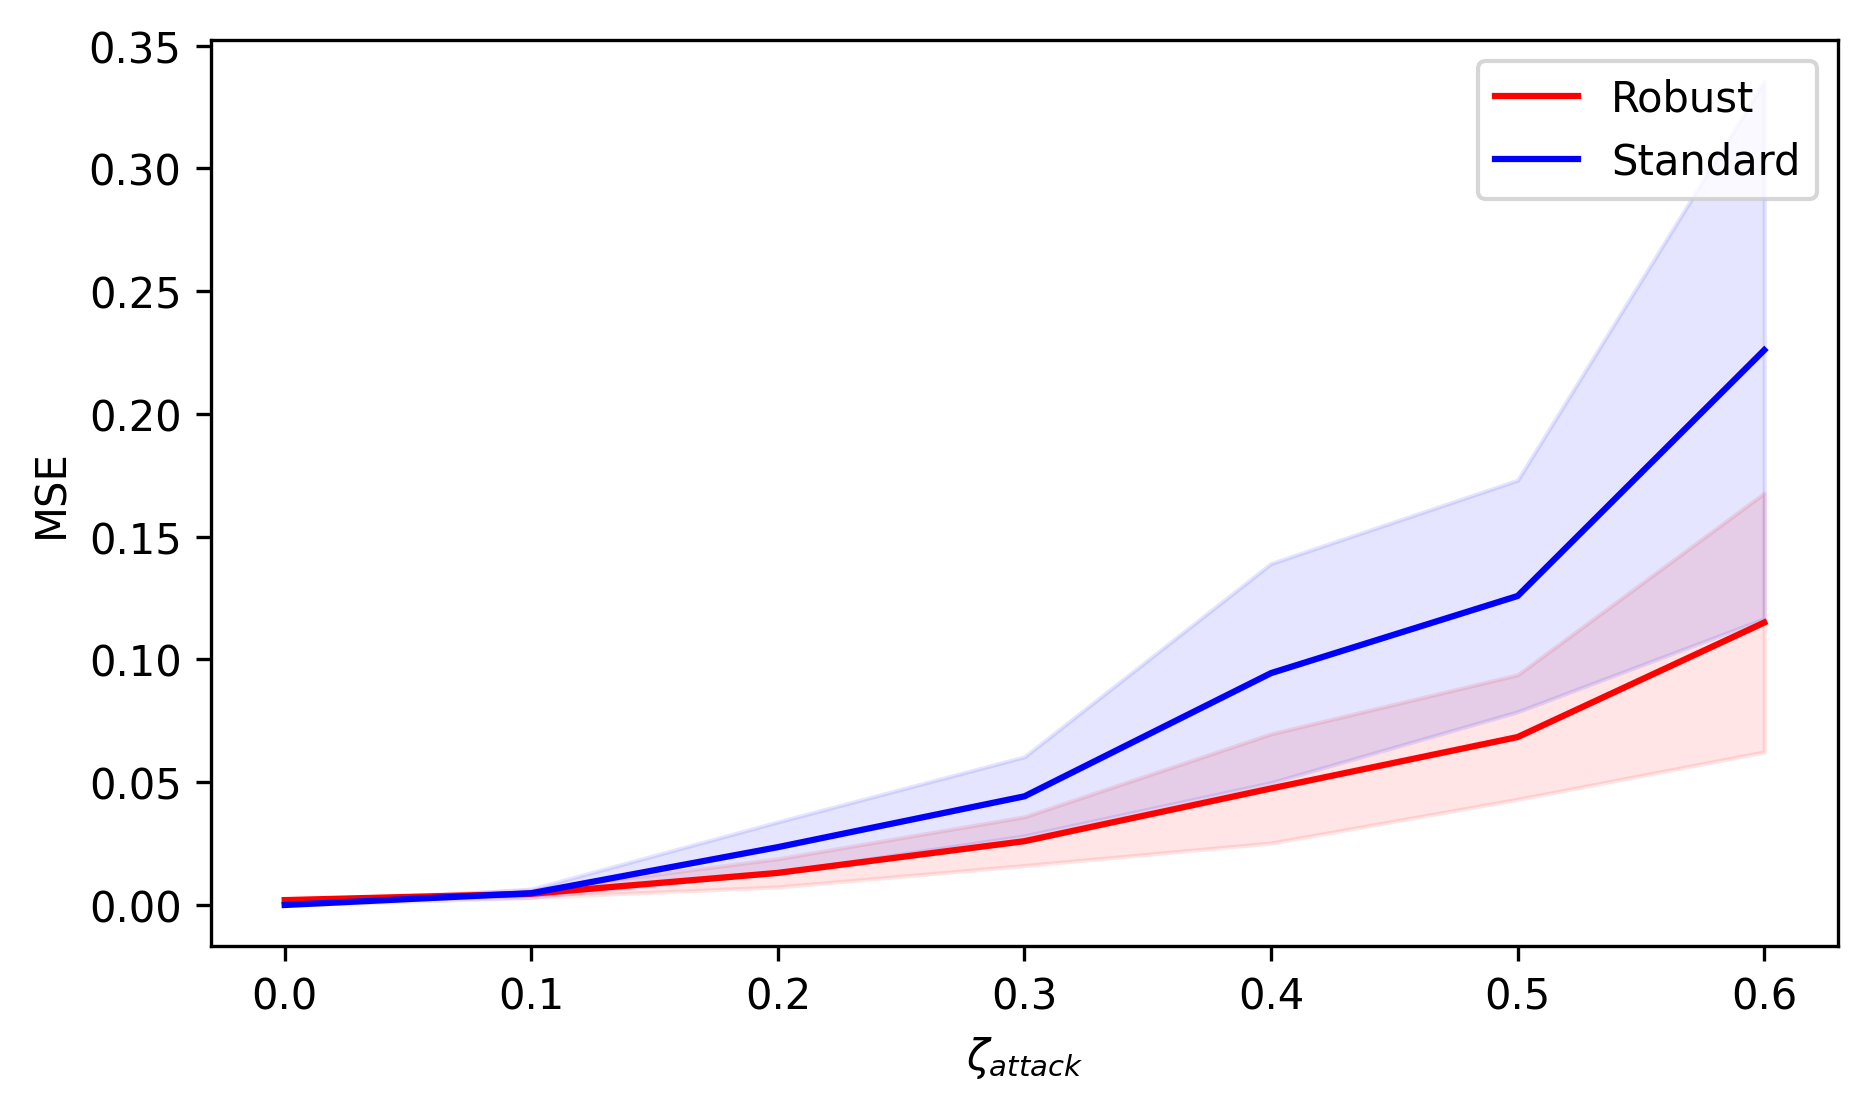

In [11]:
# - Plot the results
x = np.arange(0,len(mismatch_levels),1)
plt.plot(x, results["rob"]["mean"], color="r", label="Robust")
plt.fill_between(x, results["rob"]["mean"]-results["rob"]["std"],results["rob"]["mean"]+results["rob"]["std"], alpha=0.1, color="r")

plt.plot(x, results["standard"]["mean"], color="b", label="Standard")
plt.fill_between(x, results["standard"]["mean"]-results["standard"]["std"],results["standard"]["mean"]+results["standard"]["std"], alpha=0.1, color="b")

plt.gca().set_xticks(x)
plt.gca().set_xticklabels([str(s) for s in mismatch_levels])
plt.gca().set_xlabel(r"$\zeta_{attack}$")
plt.ylabel("MSE")
plt.legend()
plt.show()